In [2]:
import os
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
import matplotlib.pyplot as plt


In [3]:
def blur(img, kernel_size = 3):
    dummy = np.copy(img)
    h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy


In [4]:
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

In [5]:
def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

In [6]:
def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

In [7]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


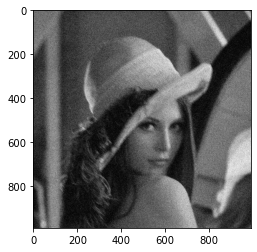

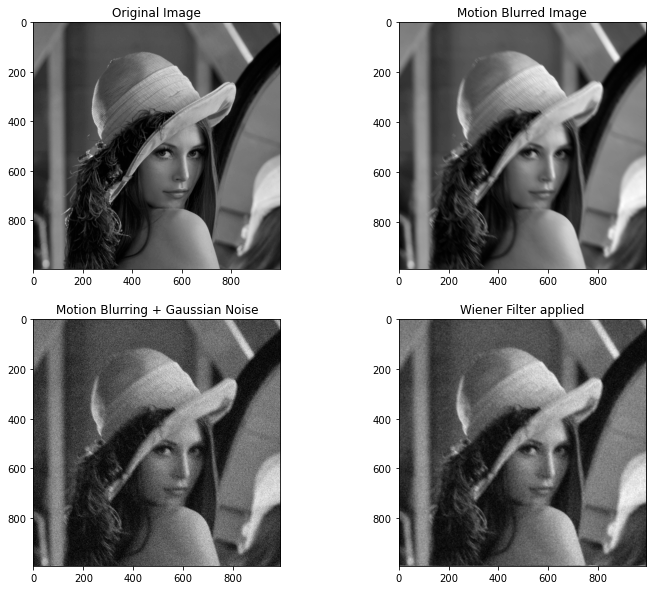

In [17]:
import scipy.misc


from scipy.signal import wiener

# Load image and convert it to gray scale
file_name = os.path.join('lena1000p.jpg') 
img = rgb2gray(plt.imread(file_name))

# Blur the image
blurred_img = blur(img, kernel_size = 10)

# Add Gaussian noise
noisy_img = add_gaussian_noise(blurred_img, sigma = 30)

# Apply Wiener Filter
kernel = gaussian_kernel(5)
filtered_img = wiener_filter(noisy_img, kernel, K = 10)

filtered_img_2= scipy.signal.wiener(noisy_img, 7, 20)

plt.imshow(filtered_img_2, cmap = 'gray')

# Display results
display = [img, blurred_img, noisy_img, filtered_img]
label = ['Original Image', 'Motion Blurred Image', 'Motion Blurring + Gaussian Noise', 'Wiener Filter applied']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()